In [9]:
from nba_api.live.nba.endpoints import scoreboard

# Today's Score Board
games = scoreboard.ScoreBoard()

# json
games.get_json()

# dictionary
games.get_dict()

{'meta': {'version': 1,
  'request': 'https://nba-prod-us-east-1-mediaops-stats.s3.amazonaws.com/NBA/liveData/scoreboard/todaysScoreboard_00.json',
  'time': '2023-11-04 06:00:30.030',
  'code': 200},
 'scoreboard': {'gameDate': '2023-11-03',
  'leagueId': '00',
  'leagueName': 'National Basketball Association',
  'games': [{'gameId': '0022300001',
    'gameCode': '20231103/CLEIND',
    'gameStatus': 3,
    'gameStatusText': 'Final',
    'period': 4,
    'gameClock': '',
    'gameTimeUTC': '2023-11-03T23:00:00Z',
    'gameEt': '2023-11-03T19:00:00Z',
    'regulationPeriods': 4,
    'ifNecessary': False,
    'seriesGameNumber': '',
    'seriesText': 'East Group A',
    'seriesConference': '',
    'poRoundDesc': '',
    'gameSubtype': 'in-season',
    'homeTeam': {'teamId': 1610612754,
     'teamName': 'Pacers',
     'teamCity': 'Indiana',
     'teamTricode': 'IND',
     'wins': 3,
     'losses': 2,
     'score': 121,
     'seed': None,
     'inBonus': None,
     'timeoutsRemaining': 0,


In [10]:
#https://www.basketball-reference.com/about/ratings.html
def calculate_olivers_ortg(df):
    # For demonstration, I'm using only the needed columns and assuming Team level data
    df = df.copy()  # Create a copy to avoid modifying the original DataFrame
    
    # Adding additional columns for Oliver's calculations
    df['FG_Part'] = df['FGM'] * (1 - 0.5 * ((df['PTS'] - df['FTM']) / (2 * df['FGA'])))
    df['AST_Part'] = 0.5 * (((df['PTS'] - df['FTM']) / (2 * df['FGA'])) * df['AST'])
    df['FT_Part'] = (1 - (1 - (df['FTM'] / df['FTA']))**2) * 0.4 * df['FTA']
    df['Team_Scoring_Poss'] = df['FGM'] + (1 - (1 - (df['FTM'] / df['FTA']))**2) * df['FTA'] * 0.4
    df['Team_ORB_Weight'] = 1  # Assuming Team_ORB% = 1 for demonstration
    df['Team_Play%'] = df['Team_Scoring_Poss'] / (df['FGA'] + df['FTA'] * 0.4 + df['TOV'])
    
    # Calculating Scoring Possessions
    df['ScPoss'] = (df['FG_Part'] + df['AST_Part'] + df['FT_Part']) * (1 - (df['OREB'] / df['Team_Scoring_Poss']) * df['Team_ORB_Weight'] * df['Team_Play%'])
    
    # Calculating Missed FG and FT Possessions
    df['FGxPoss'] = (df['FGA'] - df['FGM']) * (1 - 1.07 * 1)  # Assuming Team_ORB% as 1 for simplification
    df['FTxPoss'] = (1 - (df['FTM'] / df['FTA'])**2) * 0.4 * df['FTA']
    
    # Calculating Total Possessions
    df['TotPoss'] = df['ScPoss'] + df['FGxPoss'] + df['FTxPoss'] + df['TOV']
    
    # For demonstration, assuming Individual Points Produced (PProd) is same as ScPoss
    df['PProd'] = df['ScPoss']
    
    # Calculating Oliver's Offensive Rating (ORtg)
    df['ORtg_Oliver'] = 100 * (df['PProd'] / df['TotPoss'])
    
    return df['ORtg_Oliver']  # Return the modified DataFrame including the ORtg_Oliver column

def calculate_olivers_drtg(df):
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Constants and Intermediate Variables for the Formula
    df['FMwt'] = (df['FG_PCT_OPP'] * (1 - df['REB_OPP'] / (df['REB_OPP'] + df['REB']))) / \
                 (df['FG_PCT_OPP'] * (1 - df['REB_OPP'] / (df['REB_OPP'] + df['REB'])) + \
                  (1 - df['FG_PCT_OPP']) * (df['REB_OPP'] / (df['REB_OPP'] + df['REB'])))
    
    # Calculation of Stops1
    df['Stops1'] = df['STL'] + df['BLK'] * df['FMwt'] * (1 - 1.07 * df['REB_OPP'] / (df['REB_OPP'] + df['REB'])) + \
                   df['DREB'] * (1 - df['FMwt'])
    
    # Calculation of Stops2
    df['Stops2'] = (((df['FGA_OPP'] - df['FGM_OPP'] - df['BLK']) / df['MIN']) * df['FMwt'] * \
                    (1 - 1.07 * df['REB_OPP'] / (df['REB_OPP'] + df['REB'])) + \
                    ((df['TOV_OPP'] - df['STL']) / df['MIN'])) * df['MIN'] + \
                   (df['PF'] / df['PF_OPP']) * 0.4 * df['FTA_OPP'] * \
                   (1 - (df['FTM_OPP'] / df['FTA_OPP']) ** 2)
    
    # Total Stops
    df['Stops'] = df['Stops1'] + df['Stops2']
    
    # Calculation of Defensive Possessions (already calculated in original function)
    # df['Defensive_Possessions'] = (df['FGA_OPP'] - df['OREB_OPP']) + df['TOV_OPP'] + (0.44 * df['FTA_OPP'])
    
    # Calculation of Stop%
    df['Stop%'] = (df['Stops'] * df['MIN_OPP']) / (df['Defensive_Possessions'] * df['MIN'])
    
    # Team's Defensive Rating
    df['Team_Defensive_Rating'] = 100 * (df['PTS_OPP'] / df['Defensive_Possessions'])
    
    # Individual Defensive Rating (DRtg)
    df['D_Pts_per_ScPoss'] = df['PTS_OPP'] / (df['FGM_OPP'] + (1 - (1 - (df['FTM_OPP'] / df['FTA_OPP'])) ** 2) * df['FTA_OPP'] * 0.4)
    df['DRtg_Oliver'] = df['Team_Defensive_Rating'] + 0.2 * (100 * df['D_Pts_per_ScPoss'] * (1 - df['Stop%']) - df['Team_Defensive_Rating'])
    
    return df[['DRtg_Oliver']]  # Return only the DRtg_Oliver column

In [1]:
from nba_api.stats.endpoints import commonallplayers
from nba_api.stats.endpoints import playergamelog
import pandas as pd
import time
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to get the current NBA season year
def get_current_nba_season_year():
    current_date = datetime.now()
    if current_date.month > 9:  # NBA season starts in October
        return current_date.year
    else:
        return current_date.year - 1

# Try to read the existing max_date from the CSV, otherwise, set it to 1979
try:
    existing_data = pd.read_csv('all_players_data.csv')
    existing_data['GAME_DATE'] = pd.to_datetime(existing_data['GAME_DATE'])
    max_date = existing_data['GAME_DATE'].max()
except (FileNotFoundError, pd.errors.EmptyDataError):
    max_date = pd.to_datetime('2023-01-01')

# Retrieve all players
all_players = commonallplayers.CommonAllPlayers(is_only_current_season=0)
players_df = all_players.get_data_frames()[0]

# Convert the 'FROM_YEAR' and 'TO_YEAR' columns to integers
players_df['FROM_YEAR'] = players_df['FROM_YEAR'].astype(int)
players_df['TO_YEAR'] = players_df['TO_YEAR'].astype(int)

# Filter out players who started after the max_date
players_df = players_df[players_df['FROM_YEAR'] >= max_date.year]
print(players_df.columns)

# Get the current NBA season year
current_season_year = get_current_nba_season_year()

# Initialize a DataFrame to hold all game logs since max_date
new_players_data = pd.DataFrame()

# Loop over each player
for index, player in players_df.iterrows():
    player_id = player['PERSON_ID']
    from_year = max(max_date.year, int(player['FROM_YEAR']))  # Start from the max of max_date's year or the player's starting year
    to_year = min(current_season_year, int(player['TO_YEAR']))  # End at the current season or the player's last year

    # Generate seasons for the player since max_date
    seasons = [f"{year}-{str(year+1)[-2:]}" for year in range(from_year, to_year + 1)]

    # Fetch the player game log for each season since max_date
    for season in seasons:
        #print(f"Fetching data for Player ID: {player_id} for the {season} season.")
        player_log = playergamelog.PlayerGameLog(player_id=player_id, season=season)
        player_data = player_log.get_data_frames()[0]

        # Filter out the games before the max_date
        player_data['GAME_DATE'] = pd.to_datetime(player_data['GAME_DATE'])
        player_data_since_max_date = player_data[player_data['GAME_DATE'] > max_date]

        if not player_data_since_max_date.empty:
            new_players_data = pd.concat([new_players_data, player_data_since_max_date], ignore_index=True)
        
        # Respectful sleeping to not hammer the API
        time.sleep(1)  # Sleep for 1 second between requests

# Append the new data to the existing CSV file
#new_players_data.to_csv('all_players_data.csv', mode='a', header=False, index=False)
print(new_players_data.columns)


Index(['PERSON_ID', 'DISPLAY_LAST_COMMA_FIRST', 'DISPLAY_FIRST_LAST',
       'ROSTERSTATUS', 'FROM_YEAR', 'TO_YEAR', 'PLAYERCODE', 'PLAYER_SLUG',
       'TEAM_ID', 'TEAM_CITY', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CODE',
       'TEAM_SLUG', 'GAMES_PLAYED_FLAG', 'OTHERLEAGUE_EXPERIENCE_CH'],
      dtype='object')


KeyboardInterrupt: 

In [11]:
print(new_players_data.head())
print(new_players_data.columns)
# Function to determine home or away
def home_or_away(row):
    team = row['TEAM_ABBREVIATION']
    matchup = row['MATCHUP']
    
    if team + ' @ ' in matchup:
        return 'Away'
    elif team + ' vs. ' in matchup:
        return 'Home'
    else:
        return 'Unknown'
    
new_players_data['Home_Away'] = new_players_data.apply(home_or_away, axis=1)

#fix index
data = new_players_data.reset_index(drop=True)
print(len(data))
print(data.head())
print(data.columns)

  SEASON_ID  Player_ID     Game_ID  GAME_DATE      MATCHUP WL  MIN  FGM  FGA  \
0     22023    1641734  0022300112 2023-10-31  CLE vs. NYK  L   23    3    8   
1     22023    1641734  0022300091 2023-10-28  CLE vs. IND  L    7    0    1   
2     22023    1641710  0022300130 2023-11-02    ORL @ UTA  W   16    4    4   
3     22023    1641710  0022300114 2023-10-31    ORL @ LAC  L    4    0    0   
4     22023    1641710  0022300066 2023-10-25  ORL vs. HOU  W    5    2    2   

   FG_PCT  ...  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0   0.375  ...     5    6    1    0    1    1   1    9          -9   
1   0.000  ...     0    0    0    0    0    0   0    0         -15   
2   1.000  ...     2    3    1    2    0    1   2    9           6   
3   0.000  ...     0    0    1    0    0    0   1    0          -1   
4   1.000  ...     0    0    1    0    2    0   0    5           9   

   VIDEO_AVAILABLE  
0                1  
1                1  
2                1  
3             

KeyError: 'TEAM_ABBREVIATION'

In [12]:
#MERGING GAME_ID's for _OPP data
# Assuming data is your original dataframe

# Splitting data into data_first and data_second
data_first = data#.iloc[::2].reset_index(drop=True)
data_second = data#.iloc[1::2].reset_index(drop=True)

# Drop unnecessary columns from data_second
columns_to_drop = ['GAME_DATE', 'MATCHUP', 'TEAM_ABBREVIATION']
data_second = data_second.drop(columns=columns_to_drop)

# Merge data_first and data_second
data = data_first.merge(data_second, on='GAME_ID', suffixes=('', '_OPP'))

# Ensure TEAM_NAME from data_first isn't the same as TEAM_NAME from data_second
data = data[data.TEAM_NAME != data.TEAM_NAME_OPP]

#***making into a 1 row per game format***
#group columns by group_id to get the first one of each group
#data = data.groupby('GAME_ID').first().reset_index()
#change WL column to show TEAM_ID for the winner and TEAM_ID_OPP for the loser
#data.loc[data['WL'] == 'W', 'WL'] = data['TEAM_ID']
#data.loc[data['WL'] == 'L', 'WL'] = data['TEAM_ID_OPP']


print(len(data))
print(data.head())


13780
  SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME     GAME_ID  \
1     22023  1610612741               CHI           Chicago Bulls  0022300004   
2     22023  1610612751               BKN           Brooklyn Nets  0022300004   
5     22023  1610612757               POR  Portland Trail Blazers  0022300007   
6     22023  1610612763               MEM       Memphis Grizzlies  0022300007   
9     22023  1610612748               MIA              Miami Heat  0022300003   

    GAME_DATE      MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  FG3M  FG3A  \
1  2023-11-03  CHI vs. BKN  L  238  107   43   89   0.483    11    28   
2  2023-11-03    BKN @ CHI  W  240  109   44   96   0.458    18    45   
5  2023-11-03  POR vs. MEM  W  264  115   39   96   0.406     9    32   
6  2023-11-03    MEM @ POR  L  265  113   47   96   0.490    10    35   
9  2023-11-03  MIA vs. WAS  W  242  121   48   80   0.600    13    27   

   FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  P

In [13]:
# Create the unique matchup ID
def create_matchup_id(matchup):
    # Split the teams based on " vs. " or " @ "
    teams = matchup.split(' vs. ') if ' vs. ' in matchup else matchup.split(' @ ')
    # Sort the teams alphabetically and concatenate
    return ''.join(sorted(teams))

data['MATCHUP_ID'] = data['MATCHUP'].apply(create_matchup_id)
#This function ensures that no matter the order, the matchup will come out like this. Example below and can be used on the unseen data as well.
#data = data[data['MATCHUP_ID'] == 'HOUPOR']

#print(data.head())
print(len(data))

#look at pts and pts_opp
print(data['PTS'])
print(data['PTS_OPP'])


13780
1        107
2        109
5        115
6        113
9        121
        ... 
27605     95
27608     95
27609     88
27613    119
27614    100
Name: PTS, Length: 13780, dtype: int64
1        109
2        107
5        113
6        115
9        114
        ... 
27605     86
27608     88
27609     95
27613    100
27614    119
Name: PTS_OPP, Length: 13780, dtype: int64


In [14]:
#data adds: playoff indicator, championship indicator, conference indicator, division indicator 

import pandas as pd

def prepare_data(df):
    # Sum the statistics by team and season_id
    sum_data = df.groupby(['TEAM_ID', 'Home_Away']).agg({
        'PTS': 'sum',
        'FGM': 'sum',
        'FGA': 'sum',
        'FG3M': 'sum',
        'FG3A': 'sum',
        'FTM': 'sum',
        'FTA': 'sum',
        'AST': 'sum',
        'OREB': 'sum',
        'TOV': 'sum',
        'STL': 'sum',
        'BLK': 'sum',
        'REB': 'sum',
        'MIN': 'sum',
        'PLUS_MINUS': 'mean'  # Mean of the PLUS_MINUS remains as is
        , 'PTS_OPP': 'sum'
        , 'FGM_OPP': 'sum'
        , 'FGA_OPP': 'sum'
        , 'FG3M_OPP': 'sum'
        , 'FG3A_OPP': 'sum'
        , 'FTM_OPP': 'sum'
        , 'FTA_OPP': 'sum'
        , 'AST_OPP': 'sum'
        , 'OREB_OPP': 'sum'
        , 'TOV_OPP': 'sum'
        , 'STL_OPP': 'sum'
        , 'BLK_OPP': 'sum'
        , 'REB_OPP': 'sum'
        , 'MIN_OPP': 'sum'
        , 'PLUS_MINUS_OPP': 'mean'  # Mean of the PLUS_MINUS remains as is
    }).reset_index()
    
    #points per minute
    sum_data['PTS_PER_MIN'] = sum_data['PTS'] / sum_data['MIN']

    # Calculate FG, FG3, and FT percentages
    sum_data['FG_PCT'] = sum_data['FGM'] / sum_data['FGA']
    sum_data['FG3_PCT'] = sum_data['FG3M'] / sum_data['FG3A']
    sum_data['FT_PCT'] = sum_data['FTM'] / sum_data['FTA']
    
    # Calculate additional stats
    sum_data['TS%'] = sum_data['PTS'] / (2 * (sum_data['FGA'] + 0.44 * sum_data['FTA']))
    sum_data['eFG%'] = (sum_data['FGM'] + 0.5 * sum_data['FG3M']) / sum_data['FGA']
    sum_data['AST%'] = (sum_data['AST'] / sum_data['FGA']) * 100
    
    # Calculate offensive possessions: https://kenpom.com/blog/the-possession/
    sum_data['Offensive_Possessions'] = (sum_data['FGA'] - sum_data['OREB']) + sum_data['TOV'] + (0.44 * sum_data['FTA'])

    # Calculate Offensive Rating (ORtg) and Player Efficiency Rating (PER)
    sum_data['ORtg'] = (sum_data['PTS'] / sum_data['Offensive_Possessions']) * 100
    # Offensive Team Rating (https://www.basketball-reference.com/about/ratings.html) = (Players Points*Total FG%) + Opponents Differential= 1/5 of possessions - Times Fouled+ FTM* FT% * OAPOW (Official Adjusted Players Offensive Withstand)

    sum_data['PER%'] = ((sum_data['PTS'] + sum_data['REB'] + sum_data['AST'] + sum_data['STL'] + sum_data['BLK'] -
                         sum_data['FGM'] - sum_data['FTM'] - sum_data['TOV']) / sum_data['Offensive_Possessions']) * 100
    
    #offensirve efficiency
    sum_data['OFF_EFF'] = (sum_data['PTS'] + sum_data['AST'] + sum_data['OREB']) / sum_data['MIN']

    #_OPP stats:
    #points per minute
    sum_data['PTS_PER_MIN_OPP'] = sum_data['PTS_OPP'] / sum_data['MIN_OPP']
    # Calculate FG, FG3, and FT percentages
    sum_data['FG_PCT_OPP'] = sum_data['FGM_OPP'] / sum_data['FGA_OPP']
    sum_data['FG3_PCT_OPP'] = sum_data['FG3M_OPP'] / sum_data['FG3A_OPP']
    sum_data['FT_PCT_OPP'] = sum_data['FTM_OPP'] / sum_data['FTA_OPP']
    
    # Calculate additional stats
    sum_data['TS%_OPP'] = sum_data['PTS_OPP'] / (2 * (sum_data['FGA_OPP'] + 0.44 * sum_data['FTA_OPP']))
    sum_data['eFG%_OPP'] = (sum_data['FGM_OPP'] + 0.5 * sum_data['FG3M_OPP']) / sum_data['FGA_OPP']
    sum_data['AST%_OPP'] = (sum_data['AST_OPP'] / sum_data['FGA_OPP']) * 100

    # Calculate Defensive possessions _OPP
    sum_data['Defensive_Possessions'] = (sum_data['FGA_OPP'] - sum_data['OREB_OPP']) + sum_data['TOV_OPP'] + (0.44 * sum_data['FTA_OPP'])

    # Calculate Defensive Rating (DRtg)
    sum_data['DRtg'] = (sum_data['PTS_OPP'] / sum_data['Defensive_Possessions']) * 100

    sum_data['DPER%'] = ((sum_data['PTS_OPP'] + sum_data['REB_OPP'] + sum_data['AST_OPP'] + sum_data['STL_OPP'] + sum_data['BLK_OPP'] -
                         sum_data['FGM_OPP'] - sum_data['FTM_OPP'] - sum_data['TOV_OPP']) / sum_data['Defensive_Possessions']) * 100
    
    #difference between team and _opp stats
    sum_data['PTS_DIFF'] = sum_data['PTS'] - sum_data['PTS_OPP']
    sum_data['PTS_PER_MIN_DIFF'] = sum_data['PTS_PER_MIN'] - sum_data['PTS_PER_MIN_OPP']
    sum_data['FG_PCT_DIFF'] = sum_data['FG_PCT_OPP'] - sum_data['FG_PCT']
    sum_data['FG3_PCT_DIFF'] = sum_data['FG3_PCT_OPP'] - sum_data['FG3_PCT']
    sum_data['FT_PCT_DIFF'] = sum_data['FT_PCT_OPP'] - sum_data['FT_PCT']
    sum_data['TS%_DIFF'] = sum_data['TS%_OPP'] - sum_data['TS%']
    sum_data['eFG%_DIFF'] = sum_data['eFG%_OPP'] - sum_data['eFG%']
    sum_data['AST%_DIFF'] = sum_data['AST%_OPP'] - sum_data['AST%']
    sum_data['ORtg_DIFF'] = sum_data['DRtg'] - sum_data['ORtg']
    sum_data['PER%_DIFF'] = sum_data['DPER%'] - sum_data['PER%']

    #drop all _opp stats
    sum_data = sum_data.drop(columns=['FG_PCT_OPP', 'FG3_PCT_OPP', 'FT_PCT_OPP', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 'Defensive_Possessions',
                               'DRtg', 'DPER%', 'PLUS_MINUS_OPP'])

    


    return sum_data

prepared_data = prepare_data(data)
#print(prepared_data.head())


data_drop_columns = ['PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 'OREB', 'FGA', 'FG3A', 'OREB', 
                                    'AST', 'TOV', 'STL', 'BLK',  'Offensive_Possessions', 'SEASON_ID'
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP',  'Defensive_Possessions', 'SEASON_ID_OPP', 'Home_Away_OPP', 'PTS_PER_MIN_OPP'] #, 'DREB'

#export the data dataset without the dropped columns
future_season_data_stats = prepared_data[[col for col in prepared_data.columns if col not in data_drop_columns]]

# export X to csv to apply averages onto future nba season data on a long short-term basis
#future_season_data_stats.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\future_season_data_stats.csv', index=False)
print(future_season_data_stats.head())
print(len(future_season_data_stats))

      TEAM_ID Home_Away    MIN  PLUS_MINUS  MIN_OPP  PTS_PER_MIN    FG_PCT  \
0  1610612737      Away  55151   -4.757759    55208     0.459303  0.453171   
1  1610612737      Home  53918    1.381333    54089     0.477429  0.467705   
2  1610612738      Away  59880    3.406426    59871     0.462391  0.459398   
3  1610612738      Home  60837    6.640157    61033     0.471687  0.470076   
4  1610612739      Away  50768   -5.659155    50552     0.435885  0.454264   

    FG3_PCT    FT_PCT       TS%      eFG%       AST%        ORtg        PER%  \
0  0.348080  0.791407  0.557967  0.520161  26.443531  108.056527  115.116396   
1  0.359514  0.799123  0.574478  0.536151  27.866242  111.525678  119.687995   
2  0.362327  0.792639  0.571140  0.536268  27.285584  110.830734  122.150776   
3  0.367756  0.806440  0.583853  0.547549  28.682975  112.942228  124.234090   
4  0.340059  0.762830  0.550561  0.515319  26.490432  105.871467  112.626879   

    OFF_EFF  PTS_DIFF  PTS_PER_MIN_DIFF  FG_PCT_DI

has_23_24_schedule =  False
      SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
27613     22018  1610612742               DAL        Dallas Mavericks   
27614     22018  1610612764               WAS      Washington Wizards   
27604     22018  1610612739               CLE     Cleveland Cavaliers   
27605     22018  1610612760               OKC   Oklahoma City Thunder   
27576     22018  1610612753               ORL           Orlando Magic   
...         ...         ...               ...                     ...   
18        22023  1610612744               GSW   Golden State Warriors   
25        22023  1610612742               DAL        Dallas Mavericks   
26        22023  1610612743               DEN          Denver Nuggets   
5         22023  1610612757               POR  Portland Trail Blazers   
6         22023  1610612763               MEM       Memphis Grizzlies   

          GAME_ID  GAME_DATE      MATCHUP WL  MIN  PTS  FGM  FGA  FG_PCT  \
27613  0021800150 2

C:\Users\ghadf\AppData\Local\Temp\ipykernel_28240\422498129.py:157: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = season_data.corr()


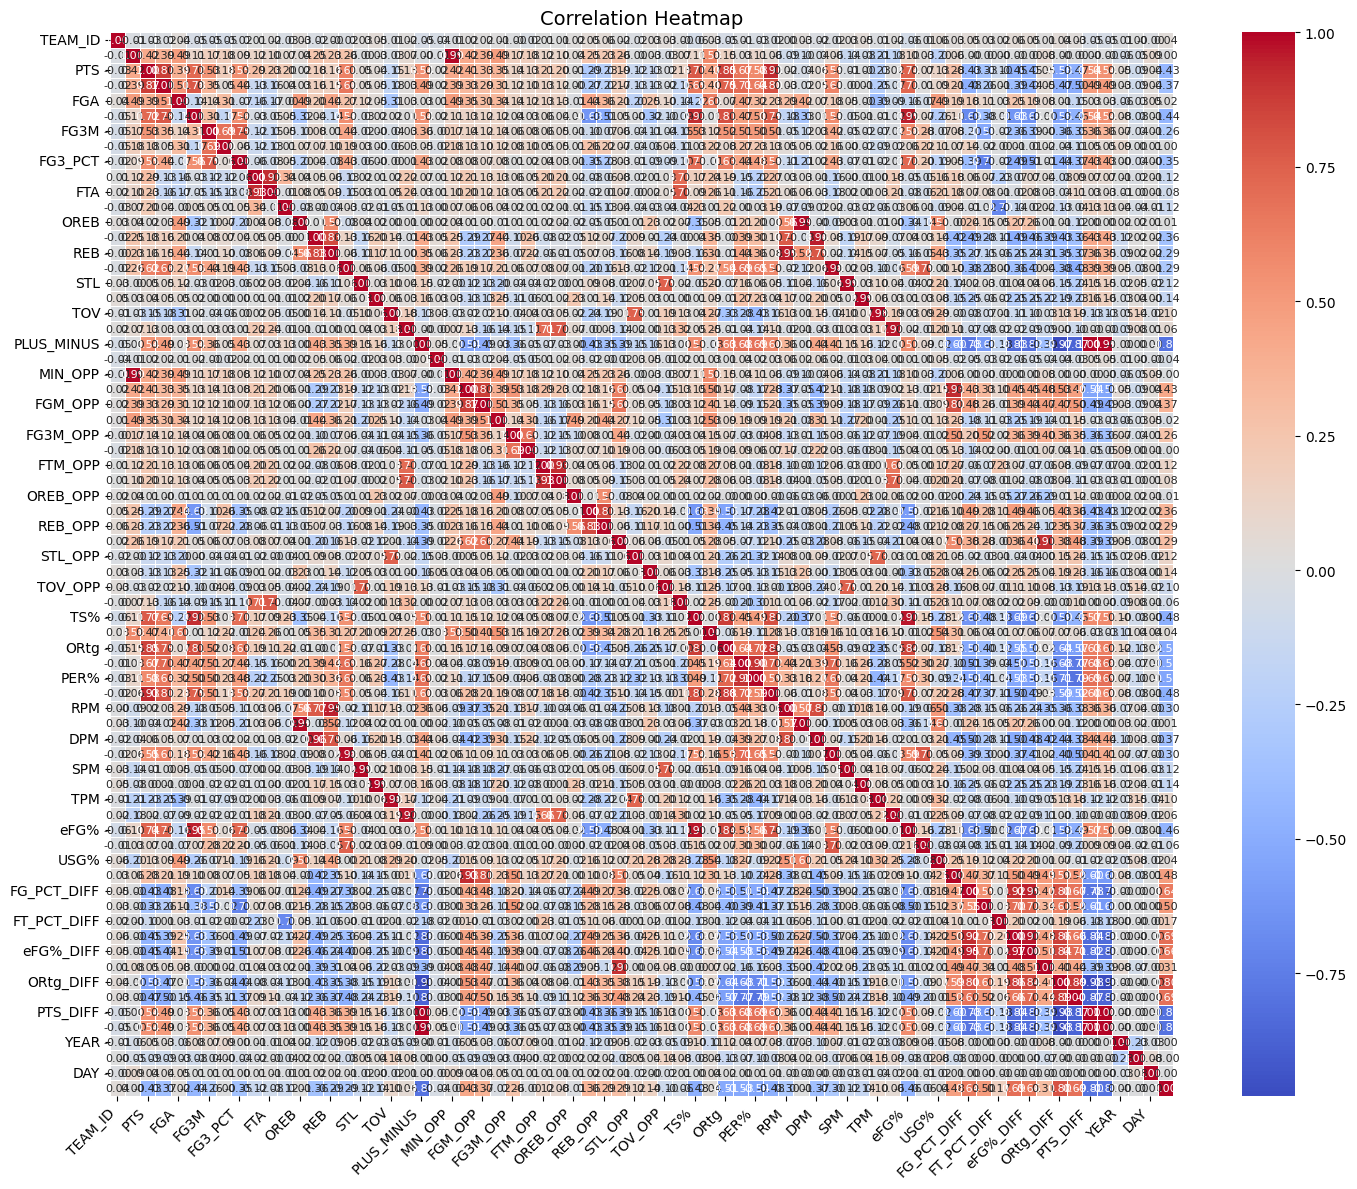

27613    19
27614   -19
27604    -9
27605     9
27576    -7
         ..
18        2
25      -11
26       11
5         2
6        -2
Name: PTS_DIFF, Length: 13754, dtype: int64


In [15]:

#print('base_data = ',data.columns)
#print(data.head())
#stat addons list: PER, TS%, eFG%, 3PAr, FTr, ORB%, DRB%, TRB%, AST%, STL%, BLK%, TOV%, USG%, OWS, DWS, WS, WS/48, OBPM, DBPM, BPM, VORP
#adding TS%= PTS / (2 * (FGA + 0.44 * FTA))
data['TS%'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA']))



#**OFF Rating add
# Calculate offensive and defensive possessions
data['Offensive_Possessions'] = data['FGA'] + 0.44 * data['FTA'] + data['TOV'] - data['OREB']
#data['Defensive_Possessions'] = data['Opponent_FGA'] + 0.44 * data['Opponent_FTA'] + data['Opponent_TOV'] - data['Opponent_OREB']

# Calculate Offensive Rating and Defensive Rating
data['ORtg'] = (data['PTS'] / data['Offensive_Possessions']) * 100
#data['DRtg'] = (data['Points_Allowed'] / data['Defensive_Possessions']) * 100

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / MIN
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])/ data['MIN']
#standardized to 48 minutes
#data['PER%'] = (data['PER'] / data['MIN']) * 48

#adding PER% = (PTS + REB + AST + STL + BLK - FGM - FTM - TOV) / OP
data['PER%'] = ((data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV']) / data['Offensive_Possessions']) * 100

# add per min function
def per_min(col):
    # Create a new column name based on the input column's name
    column_pm = col.name[0] + 'PM'
    
    # Set the new column's values to the per-minute values of the input column
    data[column_pm] = col / data['MIN']

#add points per minute  
data['PTS_PER_MIN'] = data['PTS'] / data['MIN']

#adding rebounds per minute
#data['RPM'] = data['REB'] / data['MIN']
per_min(data['REB'])
per_min(data['OREB'])
per_min(data['DREB'])

#adding assists per minute
#data['APM'] = data['AST'] / data['MIN']
per_min(data['AST'])

#adding steals per minute
#data['SPM'] = data['STL'] / data['MIN']
per_min(data['STL'])

#adding blocks per minute
#data['BPM'] = data['BLK'] / data['MIN']
per_min(data['BLK'])

#adding turnovers per minute
#data['TPM'] = data['TOV'] / data['MIN']
per_min(data['TOV'])

#adding fouls per minute
#data['FPM'] = data['PF'] / data['MIN']
per_min(data['PF'])

#adding eFG%
data['eFG%'] = (data['FGM'] + 0.5 * data['FG3M']) / data['FGA']

#adding AST%
data['AST%'] = data['AST'] / data['FGM']

#adding USG%
data['USG%'] = (data['FGA'] + 0.44 * data['FTA'] + data['TOV']) / data['MIN']
#add all the percentages to the list of columns

#_OPP stats:
data['PTS_PER_MIN_OPP'] = data['PTS_OPP'] / data['MIN_OPP']
# Calculate FG, FG3, and FT percentages
data['FG_PCT_OPP'] = data['FGM_OPP'] / data['FGA_OPP']
data['FG3_PCT_OPP'] = data['FG3M_OPP'] / data['FG3A_OPP']
data['FT_PCT_OPP'] = data['FTM_OPP'] / data['FTA_OPP']

# Calculate additional stats
data['TS%_OPP'] = data['PTS_OPP'] / (2 * (data['FGA_OPP'] + 0.44 * data['FTA_OPP']))
data['eFG%_OPP'] = (data['FGM_OPP'] + 0.5 * data['FG3M_OPP']) / data['FGA_OPP']
data['AST%_OPP'] = (data['AST_OPP'] / data['FGA_OPP']) * 100

# Calculate Defensive possessions _OPP
data['Defensive_Possessions'] = (data['FGA_OPP'] - data['OREB_OPP']) + data['TOV_OPP'] + (0.44 * data['FTA_OPP'])

# Calculate Defensive Rating (DRtg)
data['DRtg'] = (data['PTS_OPP'] / data['Defensive_Possessions']) * 100

data['DPER%'] = ((data['PTS_OPP'] + data['REB_OPP'] + data['AST_OPP'] + data['STL_OPP'] + data['BLK_OPP'] -
                        data['FGM_OPP'] - data['FTM_OPP'] - data['TOV_OPP']) / data['Defensive_Possessions']) * 100

#difference between team and _opp stats
data['FG_PCT_DIFF'] = data['FG_PCT_OPP'] - data['FG_PCT']
data['FG3_PCT_DIFF'] = data['FG3_PCT_OPP'] - data['FG3_PCT']
data['FT_PCT_DIFF'] = data['FT_PCT_OPP'] - data['FT_PCT']
data['TS%_DIFF'] = data['TS%_OPP'] - data['TS%']
data['eFG%_DIFF'] = data['eFG%_OPP'] - data['eFG%']
data['AST%_DIFF'] = data['AST%_OPP'] - data['AST%']
data['ORtg_DIFF'] = data['DRtg'] - data['ORtg']
data['PER%_DIFF'] = data['DPER%'] - data['PER%']
data['PTS_DIFF'] = data['PTS'] - data['PTS_OPP']
data['PTS_PER_MIN_DIFF'] = data['PTS_PER_MIN'] - data['PTS_PER_MIN_OPP']

#drop all _opp stats
data = data.drop(columns=['FG_PCT_OPP', 'FG3_PCT_OPP', 'FT_PCT_OPP', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 'Defensive_Possessions',
                            'DRtg', 'DPER%', 'PLUS_MINUS_OPP'])

#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Drop Missing values
# Drop rows with missing values
data_encoded = data.dropna()

# Filter the data to include only selected columns
#data_encoded_selected = data_encoded.iloc[:, :40]

# Check if the 2022-2023 NBA season is in the data. previous year was released on 8/17, see if in data then
has_23_24_schedule = any(data_encoded['SEASON_ID'] == 42023)
print('has_23_24_schedule = ',has_23_24_schedule)


# Filter the data for the 2022-2023 NBA season - changing to 1979-2023
#could also use season_id = 42022
start_date = pd.to_datetime('1979-10-01')
end_date = pd.to_datetime('2024-06-30')
season_data = data_encoded[(data_encoded['GAME_DATE'] >= start_date) & (data_encoded['GAME_DATE'] <= end_date)].copy()

#sort season_data by game_id and game_date
#proof that the dataset is team stats per game and not combined team stats per game
season_data = season_data.sort_values(by=['GAME_DATE','GAME_ID'])


# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 0 if x == 'W' else 1)
#season_data['WL_encoded_OPP'] = season_data['WL_OPP'].apply(lambda x: 0 if x == 'W' else 1)
print(season_data)



# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
season_data = season_data[[col for col in season_data.columns if col != 'WL'] + ['WL']]

# Create a correlation matrix for the selected columns
correlation_matrix = season_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 8}, linewidths=.5)  # Adjust the font size of annotations

plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x labels for better visibility
plt.yticks(rotation=0, fontsize=10)  # Adjust the y labels font size for clarity
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()  # Adjust the layout to fit the labels better
plt.show()


#In this code, we reorder the columns of season_data so that the target variable 'WL_encoded' is at the end. 
# Then, we calculate the correlation matrix using season_data.corr() and plot the heatmap using sns.heatmap(). 
# The heatmap will show the correlation values between different variables, with positive correlations in warmer colors and negative 
# correlations in cooler colors. The annot=True parameter shows the actual correlation values on the heatmap, and fmt='.2f' formats 
# the numbers to two decimal places. The cmap='coolwarm' parameter sets the color scheme for the heatmap.

print(season_data['PTS_DIFF'])

In [17]:
# Find out which columns have NaN values and the number of NaN values in each column
nan_values = data.isnull().sum()
nan_columns_before = nan_values[nan_values > 0]

print("Columns with NaN values and their counts before dropping:")
print(nan_columns_before)

# Drop columns with NaN values
data = data.dropna(axis=1)

# Check NaN columns again after dropping
nan_values_after = data.isnull().sum()
nan_columns_after = nan_values_after[nan_values_after > 0]

print("\nColumns with NaN values and their counts after dropping:")
print(nan_columns_after)


Columns with NaN values and their counts before dropping:
WL                  13
FG_PCT               3
FG3_PCT              5
FT_PCT               7
WL_OPP              13
TS%                  3
ORtg                 2
PER                  2
PER%                 2
PTS_PER_MIN          2
RPM                  2
OPM                  2
DPM                  2
APM                  2
SPM                  2
BPM                  2
TPM                  2
PPM                  2
eFG%                 3
AST%                 3
USG%                 2
PTS_PER_MIN_OPP      2
FG_PCT_DIFF          6
FG3_PCT_DIFF        10
FT_PCT_DIFF         14
TS%_DIFF             6
eFG%_DIFF            6
AST%_DIFF            5
ORtg_DIFF            4
PER%_DIFF            4
PTS_PER_MIN_DIFF     4
dtype: int64

Columns with NaN values and their counts after dropping:
Series([], dtype: int64)


In [18]:
#sort season_data by team_id and game_date
season_data = season_data.sort_values(by=["TEAM_ID", "GAME_DATE"], ascending=[True, False]).reset_index(drop=True)
#print(season_data.head())

#filter data for just the start_date = pd.to_datetime('1979-10-01') end_date = pd.to_datetime('2024-06-30')
#last_to_curr_season_data = season_data[season_data.GAME_DATE <= '2023-06-30']
#last_to_curr_season_data = season_data[season_data.GAME_DATE >= '2022-10-01']

# Save the data to a CSV file
#season_data.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_prepreprocess_data.csv', index=False)

#filter data for just the start_date = pd.to_datetime('1979-10-01') end_date = pd.to_datetime('2024-06-30')
#three_pt_era_data = season_data[season_data.GAME_DATE <= '2023-06-30']
#three_pt_era_data = season_data[season_data.GAME_DATE >= '1979-10-01']

# Save the data to a CSV file
#season_data.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_threeptera_prepreprocess_data.csv', index=False)



      WL  WL_encoded
0      W           0
1      W           0
2      W           0
3      L           1
4      L           1
...   ..         ...
13749  W           0
13750  L           1
13751  L           1
13752  W           0
13753  L           1

[13754 rows x 2 columns]
